# detecting skin, eye, iris and pupil in a still image

Let's try out different methods to extract features in the image, but first a classical one based on histograms.

http://help.simplecv.org/question/228/gaze-tracking-possible/
http://www.diku.dk/hjemmesider/ansatte/panic/eyegaze/node9.html#SECTION00061000000000000000

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

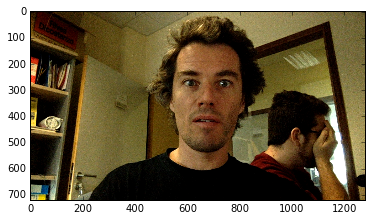

In [3]:
from openRetina import PhotoReceptor
cam = PhotoReceptor()
frame = cam.grab()
frame = cam.grab()
cam.close()
plt.imshow(frame)

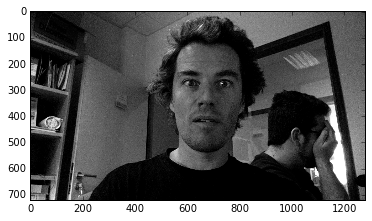

In [4]:
img_ = frame.copy()
gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap=plt.gray())

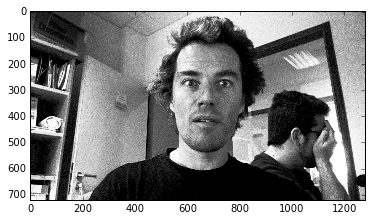

In [5]:
gray = cv2.equalizeHist(gray)
plt.imshow(gray, cmap=plt.gray())

Parameters:	

        cascade – Haar classifier cascade (OpenCV 1.x API only). It can be loaded from XML or YAML file using Load(). When the cascade is not needed anymore, release it using cvReleaseHaarClassifierCascade(&cascade).
        image – Matrix of the type CV_8U containing an image where objects are detected.
        objects – Vector of rectangles where each rectangle contains the detected object.
        scaleFactor – Parameter specifying how much the image size is reduced at each image scale.
        minNeighbors – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
        flags – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.
        minSize – Minimum possible object size. Objects smaller than that are ignored.
        maxSize – Maximum possible object size. Objects larger than that are ignored.



202 100 74 74
68 96 78 78


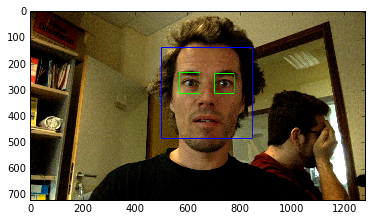

In [6]:
import cv2

face_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_eye.xml')
lefteye_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_lefteye_2splits.xml')
righteye_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_righteye_2splits.xml')

img_ = frame.copy()
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
out = frame.copy()
face, minNeighbors = [], 1
faces = face_cascade.detectMultiScale(img_, 1.3, minNeighbors) # image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]
minNeighbors += 1

eyelist = []
for (x,y,w,h) in faces:
    img_ = cv2.rectangle(img_, (x,y), (x+w,y+h), (255,0,0), 2)
    roi_color = img_[y:y+h, x:x+w]
    out_color = out[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_color, 1.1, 5, 4)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (0,255,0), 2)
        eyelist.append(out_color[ey:ey+eh, ex:ex+ew])
        print(ex,ey,ew,eh)
plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))

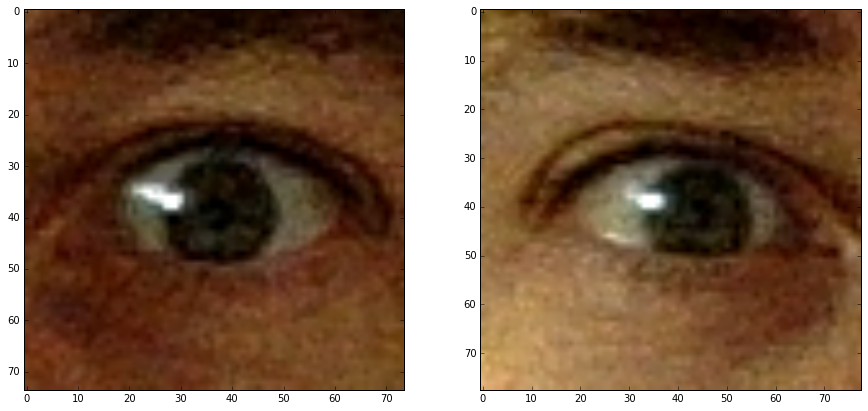

In [8]:
fig, axs = plt.subplots(1, len(eyelist), figsize=(15, 7.5))
for i, eye in enumerate(eyelist):
    axs[i].imshow(eye)

TODO : set minNeighbors then increase until we have one face only - same for eyes see http://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter

##  segmenting the different parts

- the eyebrow on upper quarter 
- the skin is all around
- the reflection is white and small
- the iris is round, darker


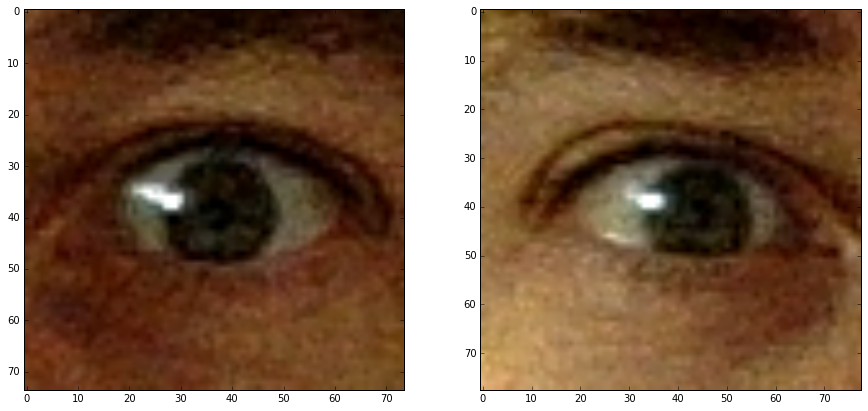

In [10]:
fig, axs = plt.subplots(1, len(eyelist), figsize=(15, 7.5))
for i, eye in enumerate(eyelist):
    axs[i].imshow(eye)

In [11]:
def otsu_thresh(hist):
    # find normalized_histogram, and its cumulative distribution function
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()

    bins = np.arange(256)

    fn_min = np.inf
    thresh = -1

    for i in range(1, 256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        b1,b2 = np.hsplit(bins,[i]) # weights

        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    return thresh


### eyebrow

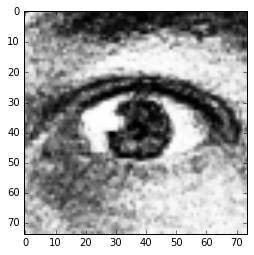

In [12]:
gray = cv2.cvtColor(eyelist[0],cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)
plt.imshow(gray, cmap = plt.cm.Greys_r)

In [14]:
help(cv2.medianBlur)

Help on built-in function medianBlur:

medianBlur(...)
    medianBlur(src, ksize[, dst]) -> dst



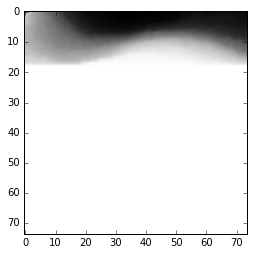

In [15]:
eyebrow = gray.copy()
eyebrow[(eyebrow.shape[0]//4):, :] = eyebrow.max()
#gray = cv2.equalizeHist(gray)
eyebrow = cv2.medianBlur(eyebrow, 19)

plt.imshow(eyebrow, cmap = plt.cm.Greys_r)

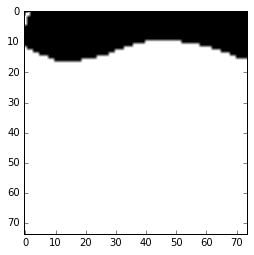

In [16]:
ret, eyebrow = cv2.threshold(eyebrow, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(eyebrow)


6 71 24 10


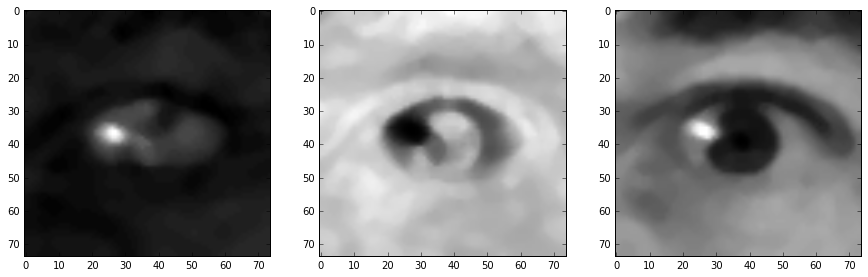

In [17]:
img = eyelist[0].copy()
blur = cv2.GaussianBlur(img,(5,5),0)
#blur = cv2.bilateralFilter(img,9,75,75)
hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)
hsv = cv2.medianBlur(hsv, 5)
print(hsv[:, :, 0].min(), hsv[:, :, 0].max(), hsv[30, 30, 0], hsv[10, 10, 0])
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(hsv[:, :, i])
    #plt.imshow(cv2.medianBlur(hsv[:, :, i], 19))

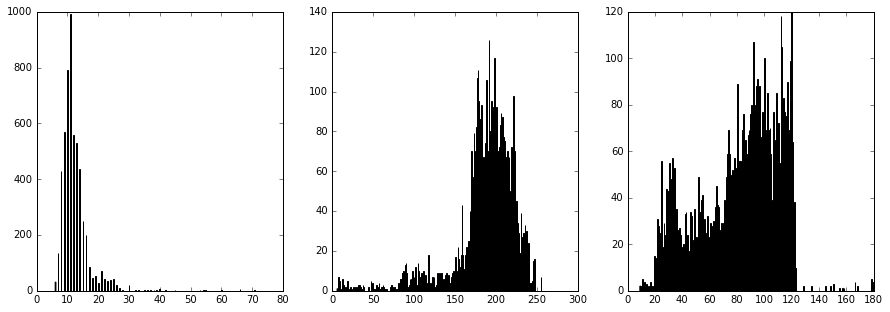

In [18]:
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(hsv[:, :, i].ravel(),256)

### reflection aka glint

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


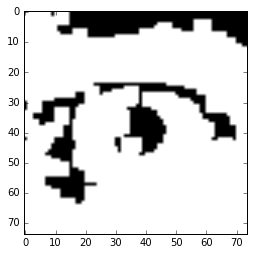

In [20]:
value = hsv[:, :, 0].copy()
value = cv2.GaussianBlur(value, (3, 3), 0)
hist = cv2.calcHist([gray], [0], eyebrow, [256], [0,256])
ret, reflection_mask = cv2.threshold(gray, otsu_thresh(hist), 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5),np.uint8)
reflection_mask = cv2.dilate(reflection_mask, kernel, iterations = 1)
plt.imshow(reflection_mask)


### skin mask

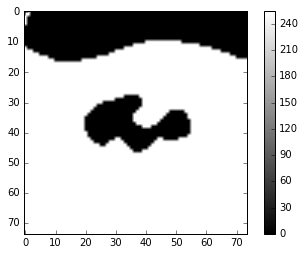

In [21]:
ret_skin, skin_mask = cv2.threshold(hsv[:, :, 0], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
skin_mask = (255 - skin_mask) * (eyebrow) * 255
plt.imshow(skin_mask)
plt.colorbar()

{'nu30': -0.0014425821334792493, 'm21': 312326612.8833333, 'm01': 177475.66666666666, 'nu11': -0.0028762552350797936, 'm20': 7389226.916666666, 'mu30': -1612598.1802995205, 'm10': 153654.0, 'm30': 397934017.90000004, 'nu03': -0.00031738217811327473, 'm02': 8771376.25, 'mu11': -49835.16668168176, 'mu21': 952864.4667375088, 'nu21': 0.0008524040719725047, 'mu03': -354787.3712053895, 'nu02': 0.06951137452160869, 'nu12': 0.0008484801064545953, 'mu20': 1717262.54045045, 'nu20': 0.09911244811372526, 'm11': 6501479.208333333, 'mu12': 948478.040823251, 'mu02': 1204382.3139572917, 'm12': 320484330.8833333, 'm03': 476330607.40000004, 'm00': 4162.5}


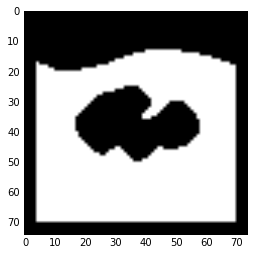

In [22]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
print (M)
skin_mask = cv2.drawContours(skin_mask, contours, -1, (0,255,0), 3)
plt.imshow(skin_mask)


In [23]:
ellipse = cv2.fitEllipse(cnt)
skin_mask = cv2.ellipse(skin_mask, ellipse,(0,255,0), 2)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

(38.152259826660156, 43.909061431884766) (63.544960021972656, 162.95782470703125) 89.03973388671875


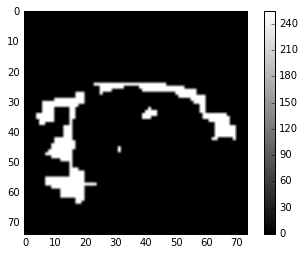

In [24]:
plt.imshow(skin_mask * (255 - reflection_mask))
plt.colorbar()

### iris

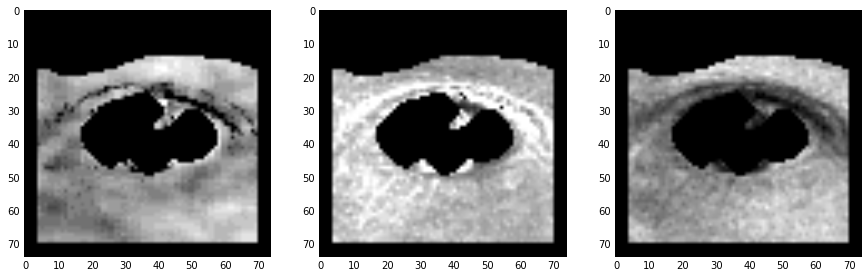

In [26]:
img = eyelist[0].copy()
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    plt.imshow(hsv[:, :, i]*skin_mask)


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


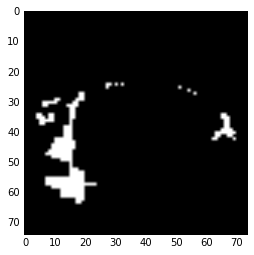

In [27]:
value = hsv[:, :, 2].copy()
hist = cv2.calcHist([value], [0], skin_mask * (255 - reflection_mask), [256], [0, 256])
ret, iris_mask = cv2.threshold(value, otsu_thresh(hist), 255, cv2.THRESH_BINARY)
iris_mask = cv2.bitwise_and(iris_mask, iris_mask, mask=skin_mask * (255 - reflection_mask))
plt.imshow(iris_mask)

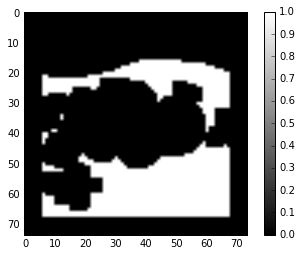

In [28]:
iris = iris_mask + skin_mask
iris = cv2.erode(iris, kernel, iterations = 1)
plt.imshow(iris)
plt.colorbar()

In [29]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

(40.25708770751953, 43.843841552734375) (56.67813491821289, 144.01258850097656) 87.9554214477539


Finally, this method proves to be insufficiently robust.